# Comet equation with MLDA
$
	\begin{cases}
		- \mu \Delta u + 10(\text{cos}\theta, \text{sin}\theta) \cdot \nabla u = 10 e^{-100 \mid \underline{x} - \underline{x}_{0} \mid} \quad\quad & \underline{x} \in \Omega = \left[0,1\right]^2\\
		u = 0 & \underline{x} \in \partial \Omega
	\end{cases}
$

## Import modules

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2021-11-04 13:11:18--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1946 (1.9K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   1.90K  --.-KB/s    in 0s      

2021-11-04 13:11:18 (23.9 MB/s) - ‘/tmp/fenics-install.sh’ saved [1946/1946]

+ PYBIND11_INSTALL_SCRIPT_PATH=https://fem-on-colab.github.io/releases/pybind11-install.sh
+ [[ https://fem-on-colab.github.io/releases/pybind11-install.sh == http* ]]
+ wget https://fem-on-colab.github.io/releases/pybind11-install.sh -O /tmp/pybind11-install.sh
--2021-11-04 13:11:18--  https://fem-on-colab.github.io/releases/pybind11-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.1

In [2]:
# Import modules

import os as os
import warnings

import sys
import time
import arviz             as az
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

import pymc3             as pm
import theano
import theano.tensor     as tt

from fenics import *

# from numpy.linalg      import inv
# from scipy.interpolate import RectBivariateSpline
# from scipy.linalg      import eigh
# from scipy.spatial     import distance_matrix

# os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable


# Further technicalities

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")

# Checking versions

print(f"Theano version: {theano.__version__}")
print(f"PyMC3  version: {pm.__version__}")

Theano version: 1.1.2
PyMC3  version: 3.11.4


## Settings

In [3]:
# System

stochastic  = False       # random seeds for the experiments

RANDOM_SEED = 123446      # Sampling seed
NUMPY_SEED  = 123         # Numpy    seed

# True model

mu    = 2                 # diffusion parameter
theta = np.pi             # advection angle parameter
n_params = 2

x_0 = np.array([0.5,0.5]) # center of the bump source-force

n_data_h = 64            # number of segments on the horizontal axis
n_data_v = 64            # number of segments on the vertical   axis

noise_level = 0.000001    # noise level in the output data


# Different mesh refinements for the models

                             #  h  v
n_data_h_v_models = np.array([[ 32, 32],   # coarse model
                              [64,64]])  # fine   model

# MCMC Settings

ndraws  = 150          # number of draws from the distribution
nburn   = 50          # number of burn-in samples

nchains = 1               # number of independent chains
nsub    = 5               # subsampling rate for MLDA

# MLDA and Metropolis tuning parameters

tune           = True
tune_interval  = 100      # set high to prevent tuning
discard_tuning = True

# Set prior parameters for random parameters (mu and theta)

lower_mu    = 0.5         # lower bound for mu (supposing mu ~ Uniform)
upper_mu    = 5         # upper bound for mu
lower_theta = 0         # lower bound for theta (supposing theta ~ Uniform)
upper_theta = 2*np.pi   # upper bound for theta

mu_0        = 3.5         # initial guess for mu random parameter
theta_0     = 2         # initial guess for theta random parameter

# Set the sigma for inference (TODO)

sigma_coarse = 0.001
sigma_fine = 0.0001

sigma = np.array([sigma_coarse, sigma_fine])

In [ ]:
# Set seed (in case it's needed)

if(not stochastic):
    np.random.seed(NUMPY_SEED)

## Define the Comet-Equation model and generate data

In [4]:
class CometEquation:
    """
    CometEquation is a class that implements the solution of the so called Comet Equation
    in the domain [0,a]x[0,b] for a given value of the parameters \mu and \theta
    """

    def __init__(self, mu, theta, x_0, n_data_h, n_data_v):

        """
        """

        # Set the parameters of the current equation

        self.mu    = mu
        self.theta = theta

        self.x_0   = x_0

        # Set the number of segments of the 2D mesh in the 2 axes

        self.n_data_h = n_data_h
        self.n_data_v = n_data_v

        # Create mesh and define function space

        mesh = UnitSquareMesh(n_data_h, n_data_v)
        V = FunctionSpace(mesh, 'P', 2)

        # Define boundary condition

        u_D = Constant(0)     # Homogeneous (null) boundary conditions

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)

        # Define variational problem: find u in V st a(u,v) = L(v) for all v in V

        u = TrialFunction(V)
        v = TestFunction (V)

        f = Expression('10*exp(-100*pow( pow(x[0]-x_00, 2) + pow(x[1]-x_01, 2), 0.5))', 
                        degree=2, x_00 = x_0[0], x_01 = x_0[1])


        b = Constant((np.cos(theta), np.sin(theta)))
        a = mu * dot(grad(u), grad(v)) * dx + 10 * dot(b,grad(u)) * v * dx
        L = f*v*dx

        # Compute solution

        u = Function(V)
        solve(a == L, u, bc)

        self.solution = u

        # Get mesh vertices and corresponding solution

        self.vertices_values    = u.compute_vertex_values()    # returns values of solution in a vector
        self.vertices_positions = mesh.coordinates()           # returns a matrix whose rows are the points of the mesh

    def plot_model(self):

        plot(self.solution)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


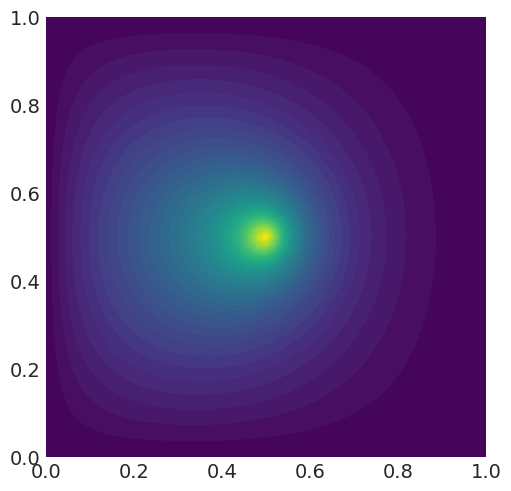

In [5]:
# Initialise a model

model_true = CometEquation(mu, theta, x_0, n_data_h, n_data_v)
model_true.plot_model()

In [6]:
u = model_true.vertices_values
np.var(u)

4.579382550460544e-08

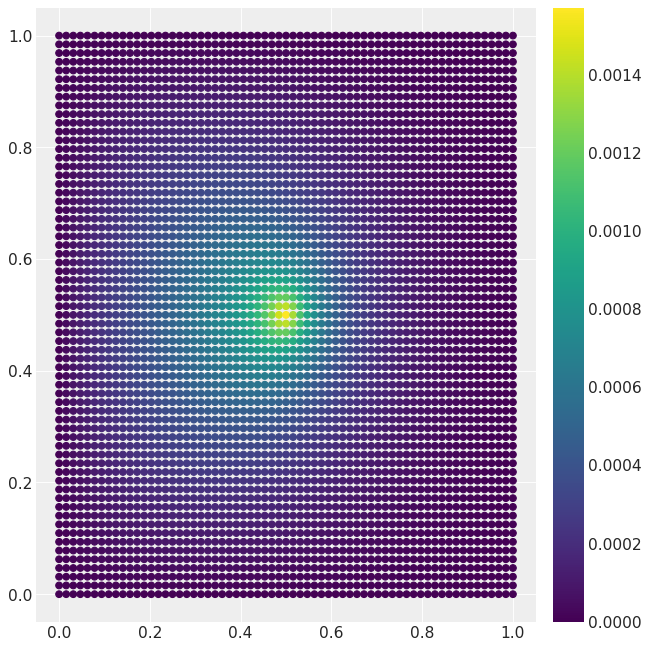

In [7]:
# Add noise to the data

noise = np.random.normal(0,noise_level, (model_true.n_data_h+1) * (model_true.n_data_v+1))
data  = model_true.vertices_values + noise

# Plot the signal

fig1 = plt.figure(figsize=(8, 8), dpi=80)

plt.scatter(x = model_true.vertices_positions[:,0], 
            y = model_true.vertices_positions[:,1],
            c = data)
plt.colorbar()
plt.show()

In [8]:
class CometEquation_Forward(CometEquation):
    """
    """

    def __init__(self, x_0, n_data_h, n_data_v, sigma):

        # Set the parameters of the current equation

        self.x_0 = x_0

        # Set sigma for the likelihood

        self.sigma = sigma

        # Set the number of segments of the 2D mesh in the 2 axes

        self.n_data_h = n_data_h
        self.n_data_v = n_data_v

    def solve(self, mu, theta):

        # Create mesh and define function space

        mesh = UnitSquareMesh(self.n_data_h, self.n_data_v)
        V = FunctionSpace(mesh, 'P', 2)

        # Define boundary condition

        u_D = Constant(0)     # Homogeneous (null) boundary conditions

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)

        # Define variational problem

        u = TrialFunction(V)
        v = TestFunction (V)

        f = Expression('10*exp(-100*pow( pow(x[0]-x_00, 2) + pow(x[1]-x_01, 2), 0.5))', 
                        degree=2, x_00 = self.x_0[0], x_01 = self.x_0[1])


        b = Constant((np.cos(theta), np.sin(theta)))
        a = mu * dot(grad(u), grad(v)) * dx + 10 * dot(b,grad(u)) * v * dx
        L = f*v*dx

        # Compute solution

        u = Function(V)
        solve(a == L, u, bc)

        self.solution = u

        # Get mesh vertices and corresponding solution

        self.vertices_values    = u.compute_vertex_values()
        self.vertices_positions = mesh.coordinates()

[0.09921431541442871, 0.2456066608428955]


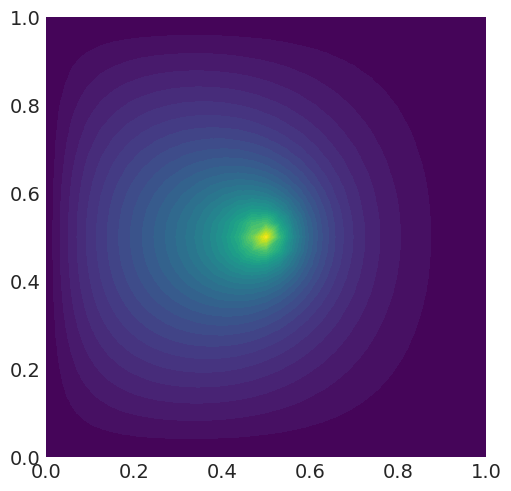

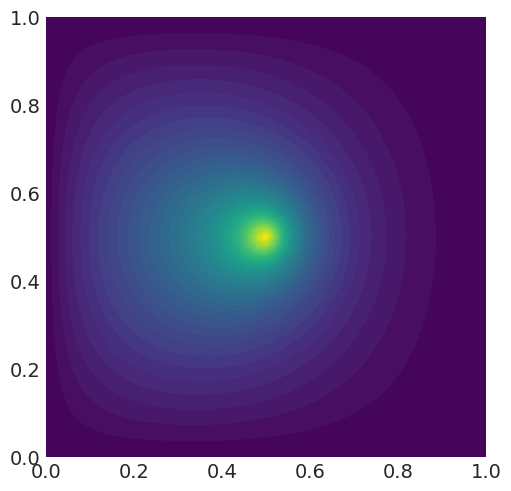

In [9]:
# Initialize the model, according to the output refinement degree

my_models = []

for i in range(n_data_h_v_models.shape[0]):
    my_models.append(CometEquation_Forward(x_0, n_data_h_v_models[i,0], n_data_h_v_models[i,1], sigma[i]))

# Plot the solutions and compare computation cost

my_models_time = []

for model in my_models:

    begin = time.time()
    model.solve(mu, theta)
    my_models_time.append(time.time()-begin)


    plt.figure()
    model.plot_model()

print(my_models_time)

# The bigger the difference in time, the more MLDA has potential to increase efficiency

## Define a Theano Op for the likelihood

See https://docs.pymc.io/en/stable/pymc-examples/examples/case_studies/blackbox_external_likelihood.html for the complete explanation of the procedure

In [10]:
# Define log likelihood

def my_loglik(my_model, mu_param, theta_param, data_xy, data_u, sigma):

    my_model.solve(mu_param, theta_param)                                    # compute the PDE solution in P1
    model_output = np.array([my_model.solution(point) for point in data_xy]) # evaluate the solution on the grid of the real data


    return - np.sum((model_output - data_u) ** 2) / (2 * sigma**2)            # compare the solution with the data

In [11]:
# Define Theano operation class to compute custom log likelihood

class LogLike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data_xy, data_u, sigma): # add inputs as class attributes

        self.my_model   = my_model
        self.likelihood = loglike
        self.data_xy    = data_xy
        self.data_u     = data_u
        self.sigma      = sigma

    def perform(self, node, inputs, outputs): # the method that is used when calling the Op
        
        (params,) = inputs  # this will contain my random parameters

        logl = self.likelihood(self.my_model, params[0], params[1], self.data_xy, self.data_u, self.sigma)

        outputs[0][0] = np.array(logl)

In [12]:
# Create Theano Ops to wrap likelihood of all model levels and store them in list

logl = []

for my_model in my_models:
    logl.append( LogLike(my_model, my_loglik, model_true.vertices_positions, data, my_model.sigma) )

## Create coarse models in PyMC3

In [13]:
# Set up models in pymc3 for each level - excluding finest model level

coarse_models = []

for j in range(len(my_models) - 1):

    with pm.Model() as model:

        # Uniform (independent?) priors

        mu_random    = pm.Uniform(name = 'mu_random',    lower = lower_mu,    upper = upper_mu)
        theta_random = pm.Uniform(name = 'theta_random', lower = lower_theta, upper = upper_theta)

        params = tt.as_tensor_variable([mu_random, theta_random])

        # Use a DensityDist (use a lamdba function to "call" the Op)

        pm.Potential("likelihood", logl[j](params))
        # pm.DensityDist("likelihood", lambda v: logl[j](v), observed={"v": params})

    coarse_models.append(model)

Calling FFC just-in-time (JIT) compiler, this may take some time.


## Create fine model and perform inference

Note that we sample using all three methods and that we use the MAP as the starting point for sampling

In [ ]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm and passing the coarse_models list created above.

method_names = []
traces       = []
runtimes     = []

with pm.Model() as model:

    # Uniform (independent?) priors

    mu_random    = pm.Uniform(name = 'mu_random',    lower = lower_mu,    upper = upper_mu)
    theta_random = pm.Uniform(name = 'theta_random', lower = lower_theta, upper = upper_theta)

    params = tt.as_tensor_variable([mu_random, theta_random])

    # Potential class to evaluate likelihood

    pm.Potential('likelihood', logl[-1](params))

    # Find the MAP estimate which is used as the starting point for sampling

    starting_point = {'mu_random': mu_0, 'theta_random': theta_0}

    # Initialise a Metropolis and MLDA object 

    step_mlda = pm.MLDA(
        coarse_models=coarse_models,
        subsampling_rates=nsub,
        base_tune_interval=tune_interval        
    )

    # MLDA inference
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(
        pm.sample(
            draws=ndraws,
            step=step_mlda,
            chains=nchains,
            tune=nburn,
            discard_tuned_samples=discard_tuning,
            random_seed=RANDOM_SEED,
            cores=1,
            start=starting_point
        )
    )
    runtimes.append(time.time() - t_start)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Only 200 samples in chain.
Sequential sampling (1 chains in 1 job)
MLDA: [theta_random, mu_random]


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

In [ ]:
starting_point

## Visulize summary quantities

In [ ]:
# summary quantities
ess = []    # collect ESS
ess_n = []  # collect ESS normlized wst number of samples
acc = []    # collect acceptance rates
performances = []   #collect ESS per second

with model:
    #print(
        #f"\nDetailed summaries and plots:\nMAP estimate: {MAP['theta']}. Not used as starting point.")
    for i, trace in enumerate(traces):
        print(f"\n{method_names[i]} Sampler:\n")
        print('mu: ',mu)
        print('theta :', theta)
        display(pm.stats.summary(trace))
        ess.append(np.array(pm.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        acc.append(trace.get_sampler_stats('accepted').mean())
        performances.append(ess[i] / runtimes[i])
        print(f"\n{method_names[i]} Sampler:\n"
              f'\nAcceptance rate: {acc[i]}'
              f'\nRuntime: {runtimes[i]} seconds'
              f'\nESS list: {ess[i]}'
              f'\nNormalised ESS list: {ess_n[i]}'
              f'\nESS/sec: {performances[i]}')


## Plot ESS and ESS per second quantities

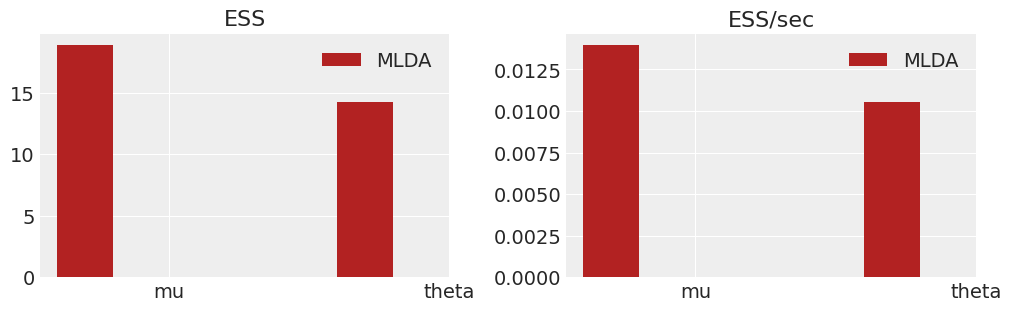

In [ ]:
# Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies.
with model:
    colors = ["firebrick",  "darkcyan"]

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    axes[0].set_title("ESS")
    for i, e in enumerate(ess):
        axes[0].bar(
            [j + i * 0.2 for j in range(n_params)],
            e.ravel(),
            width=0.2,
            color=colors[i],
            label=method_names[i],
        )
    axes[0].set_xticks([i + 0.3 for i in range(n_params)])
    axes[0].set_xticklabels(["mu", "theta"])
    axes[0].legend()

    axes[1].set_title("ESS/sec")
    for i, p in enumerate(performances):
        axes[1].bar(
            [j + i * 0.2 for j in range(n_params)],
            p.ravel(),
            width=0.2,
            color=colors[i],
            label=method_names[i],
        )
    axes[1].set_xticks([i + 0.3 for i in range(n_params)])
    axes[1].set_xticklabels(["mu", "theta"])
    axes[1].legend()
    plt.show()

## Plot traces and posteriors

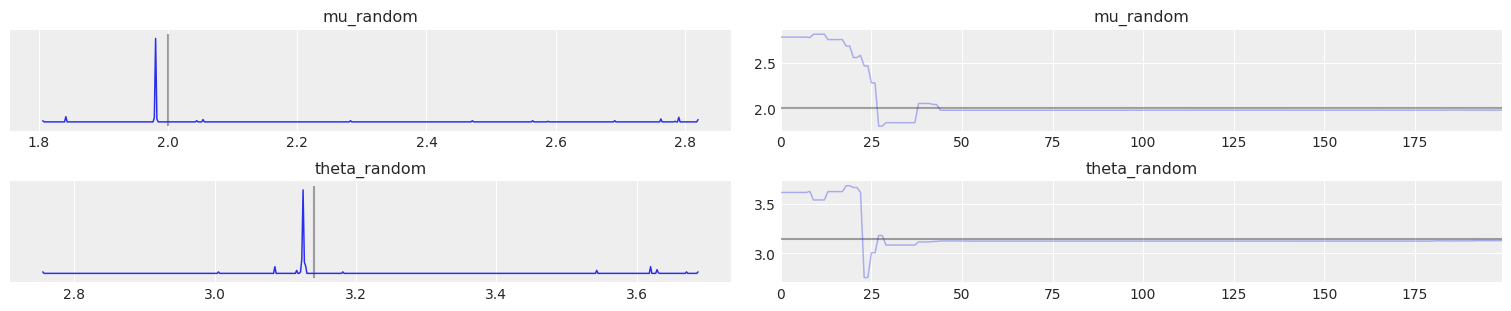

In [ ]:
# Plot traces and posteriors

with model:
    #lines = (("theta", {}, MAP["theta"].tolist()),)
    my_lines = [['mu_random', {}, mu], ('theta_random', {}, theta)]
    for i, trace in enumerate(traces):
        az.plot_trace(trace, lines=my_lines, figsize=(15,3))
        #az.plot_trace(trace, figsize=(15,3))

## Plot autocorrelation

Got error No model on context stack. trying to find log_likelihood in translation.


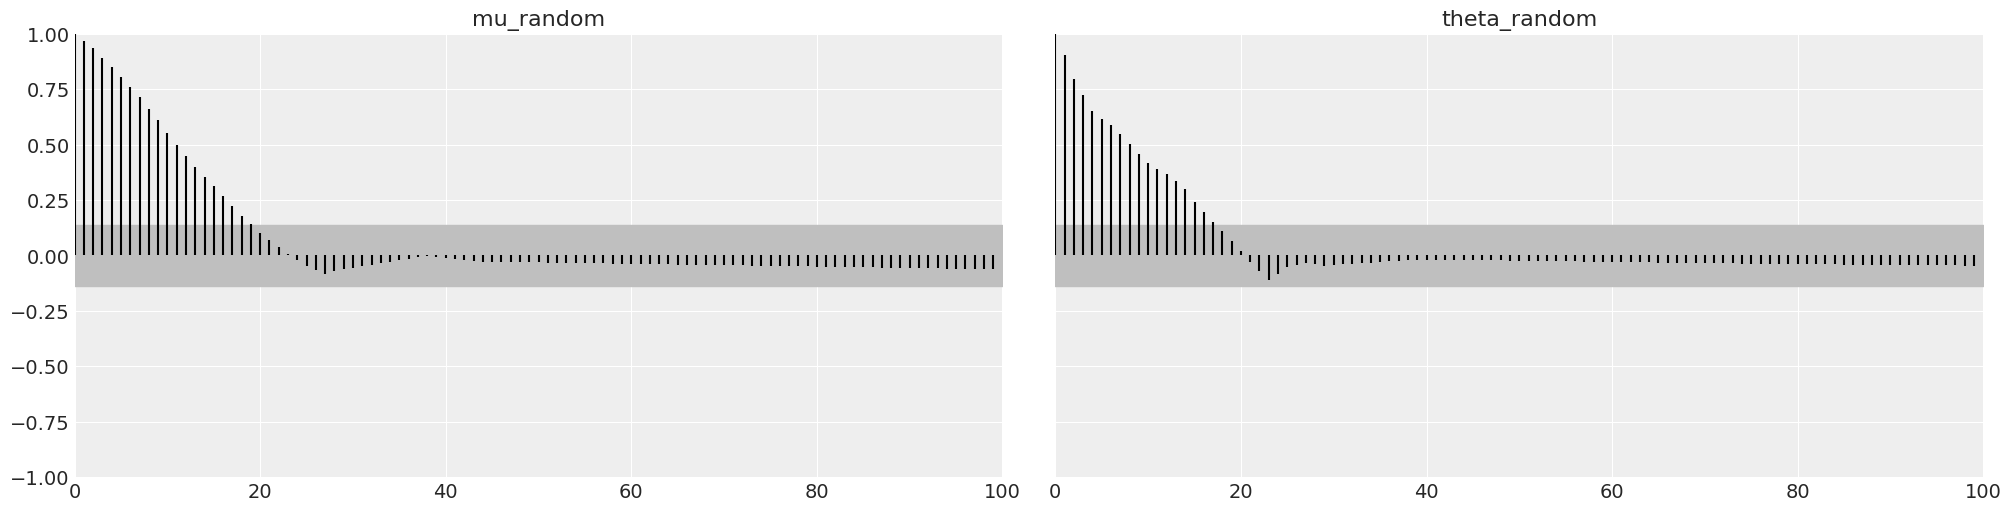

In [ ]:
# Plot autocorrelation
# il primo Metropolis
# il secondo è MLDA
for i, trace in enumerate(traces):
    az.plot_autocorr(trace, figsize=(20,5), combined=True)

# Some diagnostic plots

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


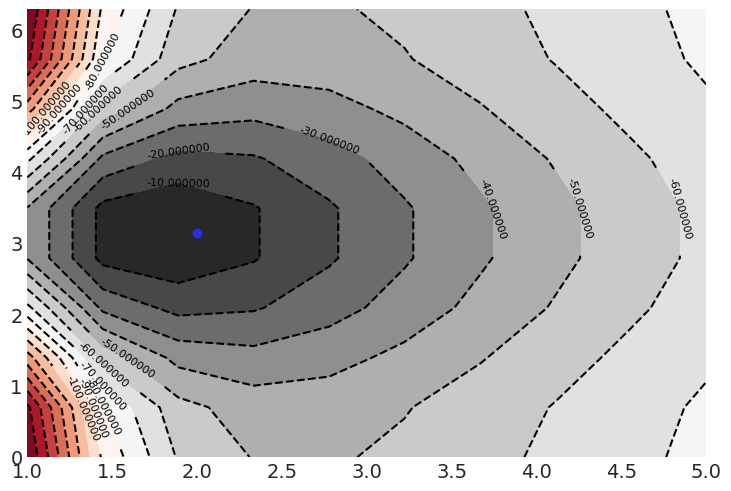

In [ ]:
# Log likelihood as a function of the random parameters

n_range = 10

mu_range    = np.linspace(1,   5,       n_range)
theta_range = np.linspace(0,   2*np.pi, n_range)

mu_test, theta_test = np.meshgrid(mu_range,theta_range)

loglik_test = np.ones(shape = mu_test.shape)

#model_output = np.ones((model_true.vertices_positions.shape[0],len(mu_test)**2))
#k=0;

for i in range(len(mu_test)):
    for j in range(len(mu_test)):

        loglik_test[i][j] = my_loglik(my_models[0], mu_test[i][j], theta_test[i][j], model_true.vertices_positions, data, my_models[0].sigma)      
        #loglik_test[i][j], model_output[:,k] = my_loglik(my_models[0], mu_test[i][j], theta_test[i][j], model_true.vertices_positions, data, sigma)
        #k = k+1

n_level = 15

contours = plt.contour(mu_test, theta_test, loglik_test, n_level, colors='black')
plt.clabel(contours, inline=True, fontsize=8, fmt="%1.6f")

plt.contourf(mu_test, theta_test, loglik_test, n_level, cmap='RdGy')

plt.scatter(mu,theta)